# METAGENOMIKA

## Daria Kalińska-Łysiak

# "Moving Pictures" tutorial

**_note:_ This guide assumes you have QIIME 2 installed (e.g. using this [procedure](https://docs.qiime2.org/2019.10/install/native/)). To execute the script properly, open this notebook in a Jupyter Notebook from within a conda QIIME 2 environment.**

**_note:_ This tutorial is an adaptation of the same tutorial that may be found on the [official QIIME 2 docs website](https://docs.qiime2.org/2019.10/tutorials/moving-pictures/). The original tutorial uses the QIIME 2 CLI interface.**

Instead of CLI interface, this tutorial uses [Artifact API](https://docs.qiime2.org/2019.10/interfaces/artifact-api/) - a Python 3 application programmer interface (API) for QIIME 2. The Artifact API supports interactive computing with QIIME 2 using the Python 3 programming language. The API is automatically generated, and its availability depends on which QIIME 2 plugins are currently installed. It has been optimized for use in the Jupyter Notebook. The Artifact API is a part of the QIIME 2 framework; no additional software needs to be installed to use it. 

**The notebook was tested using the `2019.10` version of QIIME 2.**

## Before you start: close this notebook and Jupyter session, and run `jupyter serverextension enable --py qiime2 --sys-prefix`. Then, restart this notebook.

In this tutorial you’ll use QIIME 2 to perform an analysis of human microbiome samples from two individuals at four body sites at five timepoints, the first of which immediately followed antibiotic usage. A study based on these samples was originally published in [Caporaso et al. (2011)](https://www.ncbi.nlm.nih.gov/pubmed/21624126). The data used in this tutorial were sequenced on an Illumina HiSeq using the [Earth Microbiome Project](http://earthmicrobiome.org/) hypervariable region 4 (V4) 16S rRNA sequencing protocol.

> Question 1: Why is 16S rRNA marker gene sequencing so often used to study the microbiome? What other marker genes are commonly used to identify Bacteria and Archaea? What marker genes do we use to identify other microbial kingdoms (e.g. Fungi and microbial Eukaryotes)?

Let's import all necessary modules

In [1]:
%matplotlib inline
import qiime2
from tempfile import mkdtemp
from qiime2.plugins import demux, dada2, deblur, quality_filter, \
                           metadata, feature_table, alignment, \
                           phylogeny, diversity, emperor, feature_classifier, \
                           taxa, composition

Before beginning this tutorial, create a new directory and change to that directory. The following two commands should do it for you. 

#### make sure to change the path in workdir

In [2]:
! pwd

/mnt/Dane/ICM_remote/zad5_metagenomika


In [3]:
workdir='/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2'

In [4]:
!mkdir -p $workdir
!cd $workdir

## Sample metadata

Before starting the analysis, explore the sample metadata to familiarize yourself with the samples used in this study. The [sample metadata](https://docs.google.com/spreadsheets/d/16oomVnULW-uesehNZc_mKIDTnuRoTiun0CpzSFZagvo/edit#gid=0) is available as a Google Sheet. You can download this file as tab-separated text by selecting `File` > `Download as` > `Tab-separated values`. Alternatively, the following command will download the sample metadata as tab-separated text and save it in the file `sample-metadata.tsv`. This `sample-metadata.tsv` file is used throughout the rest of the tutorial.

In [5]:
!wget -O $workdir/"sample-metadata.tsv" "https://data.qiime2.org/2019.10/tutorials/moving-pictures/sample_metadata.tsv"

--2020-03-12 22:12:12--  https://data.qiime2.org/2019.10/tutorials/moving-pictures/sample_metadata.tsv
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://docs.google.com/spreadsheets/d/16oomVnULW-uesehNZc_mKIDTnuRoTiun0CpzSFZagvo/export?gid=0&format=tsv [following]
--2020-03-12 22:12:13--  https://docs.google.com/spreadsheets/d/16oomVnULW-uesehNZc_mKIDTnuRoTiun0CpzSFZagvo/export?gid=0&format=tsv
Resolving docs.google.com (docs.google.com)... 2a00:1450:401b:805::200e, 172.217.16.14
Connecting to docs.google.com (docs.google.com)|2a00:1450:401b:805::200e|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/sample-metadata.tsv’

/mnt/Dane/ICM_remot     [ <=>                ]   2,04K  --.-KB/s    in 0s 

## Obtaining and importing data

Download the sequence reads that we’ll use in this analysis. In this tutorial we’ll work with a small subset of the complete sequence data so that the commands will run quickly.

_Make new directory for the archives to be downloaded._

In [6]:
!mkdir $workdir/emp-single-end-sequences

mkdir: cannot create directory ‘/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/emp-single-end-sequences’: File exists


Download `barcodes.fastq.gz` archive containing barcode sequances identifying individual samples.

In [7]:
!wget -O $workdir/"emp-single-end-sequences/barcodes.fastq.gz" "https://data.qiime2.org/2019.10/tutorials/moving-pictures/emp-single-end-sequences/barcodes.fastq.gz"

--2020-03-12 22:12:13--  https://data.qiime2.org/2019.10/tutorials/moving-pictures/emp-single-end-sequences/barcodes.fastq.gz
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/tutorials/moving-pictures/emp-single-end-sequences/barcodes.fastq.gz [following]
--2020-03-12 22:12:14--  https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/tutorials/moving-pictures/emp-single-end-sequences/barcodes.fastq.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.251.24
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.251.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3783785 (3,6M) [application/x-gzip]
Saving to: ‘/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/emp-single-end-sequences/barcodes.fast

Download `sequences.fastq.gz` archive containing all the reads sequanced.

In [8]:
!wget -O $workdir/"emp-single-end-sequences/sequences.fastq.gz" "https://data.qiime2.org/2019.10/tutorials/moving-pictures/emp-single-end-sequences/sequences.fastq.gz"

--2020-03-12 22:12:17--  https://data.qiime2.org/2019.10/tutorials/moving-pictures/emp-single-end-sequences/sequences.fastq.gz
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/tutorials/moving-pictures/emp-single-end-sequences/sequences.fastq.gz [following]
--2020-03-12 22:12:17--  https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/tutorials/moving-pictures/emp-single-end-sequences/sequences.fastq.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.251.24
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.251.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25303756 (24M) [binary/octet-stream]
Saving to: ‘/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/emp-single-end-sequences/sequences

To give an over-simplistic definition, a QIIME 2 artifact is a file containing any type of data.

### Import data as a qiime2 artifact

All data that is used as input to QIIME 2 is in form of QIIME 2 artifacts, which contain information about the type of data and the source of the data. So, the first thing we need to do is import these sequence data files into a QIIME 2 artifact.

The semantic type of this QIIME 2 artifact is `EMPSingleEndSequences`. `EMPSingleEndSequences` QIIME 2 artifacts contain sequences that are multiplexed, meaning that the sequences have not yet been assigned to samples (hence the inclusion of both `sequences.fastq.gz` and `barcodes.fastq.gz` files, where the `barcodes.fastq.gz` contains the barcode read associated with each sequence in `sequences.fastq.gz.`) 


In [9]:
single_end_sequences = qiime2.Artifact.import_data('EMPSingleEndSequences', workdir+'/emp-single-end-sequences/')

### Read metadata into `qiime2.Metadata` object

In [10]:
sample_metadata = qiime2.Metadata.load(workdir+'/sample-metadata.tsv')

## Demultiplexing sequences 

> Question 2: What is demultiplexing and why do we need to demultiplex? 

To demultiplex sequences we need to know which barcode sequence is associated with each sample. This information is contained in the [sample metadata](https://docs.google.com/spreadsheets/d/16oomVnULW-uesehNZc_mKIDTnuRoTiun0CpzSFZagvo/edit#gid=0) file. You can run the following commands to demultiplex the sequences (the `demux.methods.emp-single` function refers to the fact that these sequences are barcoded according to the [Earth Microbiome Project](http://earthmicrobiome.or-g/) protocol, and are single-end reads). The `demux.qza` QIIME 2 artifact will contain the demultiplexed sequences.

In [11]:
demux_sequences = demux.methods.emp_single(single_end_sequences,
                                           sample_metadata.get_column('barcode-sequence'))

After demultiplexing, it’s useful to generate a summary of the demultiplexing results. This allows you to determine how many sequences were obtained per sample, and also to get a summary of the distribution of sequence qualities at each position in your sequence data.

<visualization: Visualization uuid: 4f75b97c-3b70-43ce-8b3d-8b7c2d97dc8f>

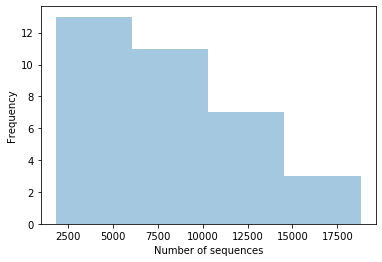

In [12]:
demux_summary = demux.visualizers.summarize(demux_sequences.per_sample_sequences)
demux_summary.visualization


## Sequence quality control and feature table construction

QIIME 2 plugins are available for several quality control methods, including DADA2, Deblur, and basic quality-score-based filtering. In this tutorial we present this step using [DADA2](https://www.ncbi.nlm.nih.gov/pubmed/27214047) and [Deblur](https://msystems.asm.org/content/2/2/e00191-16). These steps are interchangeable, so you can use whichever of these you prefer. The result of both of these methods will be a `FeatureTable[Frequency]` QIIME 2 artifact, which contains counts (frequencies) of each unique sequence in each sample in the dataset, and a `FeatureData[Sequence]` QIIME 2 artifact, which maps feature identifiers in the `FeatureTable` to the sequences they represent.

## Option 1: DADA2

[DADA2](https://www.ncbi.nlm.nih.gov/pubmed/27214047) is a pipeline for detecting and correcting (where possible) Illumina amplicon sequence data. As implemented in the `q2-dada2` plugin, this quality control process will additionally filter any phiX reads (commonly present in marker gene Illumina sequence data) that are identified in the sequencing data, and will filter chimeric sequences.

The `dada2.methods.denoise_single` method requires two parameters that are used in quality filtering: `trim_left`, which trims off the first `m` bases of each sequence, and `trunc_len` which truncates each sequence at position `n`. This allows the user to remove low quality regions of the sequences. To determine what values to pass for these two parameters, you should review the Interactive Quality Plot tab in the `demux.qzv` file that was generated by qiime demux summarize above.

In the `demux.qzv` quality plots, we see that the quality of the initial bases seems to be high, so we won’t trim any bases from the beginning of the sequences. The quality seems to drop off around position 120, so we’ll truncate our sequences at 120 bases. This next command may take up to 10 minutes to run, and is the slowest step in this tutorial.


In [13]:
denoised_sequences = dada2.methods.denoise_single(demux_sequences.per_sample_sequences, trim_left = 0, \
trunc_len = 120)

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada_single.R /tmp/qiime2-archive-bmuezr85/a623ffee-01d1-48e8-afae-0086ca2d1f07/data /tmp/tmpb4i0gnf7/output.tsv.biom /tmp/tmpb4i0gnf7/track.tsv /tmp/tmpb4i0gnf7 120 0 2.0 2 Inf consensus 1.0 1 1000000 NULL 16



In [14]:
denoise_stats = metadata.visualizers.tabulate(denoised_sequences.denoising_stats.view(qiime2.Metadata))
denoise_stats.visualization

<visualization: Visualization uuid: 0bc1e339-dfbe-4f95-8424-38373943ebcc>

**If you want to stay with Option 1, go straight to FeatureTable and FeatureData summaries. If you want to try Option 2, denoising sequances with Deblur, proceed to the next cell.**

## Option 2: Deblur

Deblur uses sequence error profiles to associate erroneous sequence reads with the true biological sequence from which they are derived, resulting in high quality sequence variant data. This is applied in two steps. First, an initial quality filtering process based on quality scores is applied. This method is an implementation of the quality filtering approach described by [Bokulich et al. (2013)](https://www.nature.com/articles/nmeth.2276).

In [15]:
demux_filter_stats = quality_filter.methods.q_score(demux_sequences.per_sample_sequences)

/opt/conda-envs/qiime2-2019.10/lib/python3.6/site-packages/q2_quality_filter/_filter.py:88: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  phred_offset = yaml.load(metadata_view)['phred-offset']


Next, the Deblur workflow is applied using the `deblur.methods.denoise-16S method`. This method requires one parameter that is used in quality filtering, `trim_length = n` which truncates the sequences at position `n`. In general, the Deblur developers recommend setting this value to a length where the median quality score begins to drop too low. On these data, the quality plots (prior to quality filtering) suggest a reasonable choice is in the 115 to 130 sequence position range. This is a subjective assessment. One situation where you might deviate from that ecommendation is when performing a meta-analysis across multiple sequencing runs. In this type of meta-analysis, it is critical that the read lengths be the same for all of the sequencing runs being compared to avoid introducing a study-specific bias. Since 120 is reasonable given the quality plots, we’ll pass `trim_length` parameter the value of 120. This next command may take up to 10 minutes to run.

In [16]:
denoised_sequences = deblur.methods.denoise_16S(demux_sequences.per_sample_sequences,
                                             trim_length=120,
                                              sample_stats=True)

The two commands used in this section generate QIIME 2 artifacts containing summary statistics. To view those summary statistics, you can visualize them using `metadata.visualizers.tabulate` and `deblur.visulaizers.visualize-stats`, respectively.
> Question 3: Look at generated filtering stats after demultiplexing. Pay attention to columns names. What is the meaning of `reads-too-short-after-truncation` and `reads-exceeding-maximum-ambiguous-bases` columns in the context of filtering?

> Question 4: Look at statistics visulization after appling denoising using Deblur. How do you understand `reads-missed-reference`, `reads-hit-artifact`, `reads-derep`, `reads-chimeric` in context of methodology (sequancing errors, using reference data bases)?

In [17]:
filter_stats = metadata.visualizers.tabulate(demux_filter_stats.filter_stats.view(qiime2.Metadata))
filter_stats.visualization

<visualization: Visualization uuid: f062ecb6-c007-40ef-a991-0847f8ceb13e>

In [18]:
denoise_stats = deblur.visualizers.visualize_stats(denoised_sequences.stats)
denoise_stats.visualization

<visualization: Visualization uuid: 644cd885-952e-4c4b-b68d-ab1fc246feff>


## FeatureTable and FeatureData summaries

After the quality filtering step completes, you’ll want to explore the resulting data. You can do this using the following two commands, which will create visual summaries of the data. The `feature_table.visulizers.summarize` function will give you information on how many sequences are associated with each sample and with each feature, histograms of those distributions, and some related summary statistics. The `feature_table.visulizers.tabulate_seqs` command will provide a mapping of feature IDs to sequences, and provide links to easily BLAST each sequence against the NCBI nt database. The latter visualization will be very useful later in the tutorial, when you want to learn more about specific features that are important in the data set.


/opt/conda-envs/qiime2-2019.10/lib/python3.6/site-packages/q2_feature_table/_summarize/_visualizer.py:122: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  os.path.join(output_dir, 'sample-frequency-detail.csv'))
/opt/conda-envs/qiime2-2019.10/lib/python3.6/site-packages/q2_feature_table/_summarize/_visualizer.py:124: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  os.path.join(output_dir, 'feature-frequency-detail.csv'))


<visualization: Visualization uuid: d7916666-10b7-4a6a-b148-81b4c13c7059>

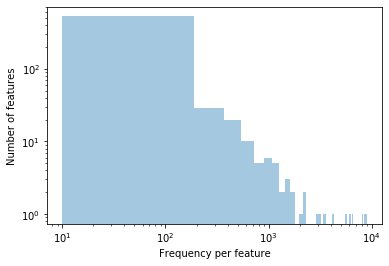

In [19]:
output_viz = feature_table.visualizers.summarize(denoised_sequences.table)
output_viz.visualization

In [20]:
denoise_feature_table_summary = feature_table.visualizers.tabulate_seqs(denoised_sequences.representative_sequences)
denoise_feature_table_summary.visualization

<visualization: Visualization uuid: 7f88dcaf-1acb-4762-9cbd-59c53f6f9946>


## Generate a tree for phylogenetic diversity analyses

QIIME supports several phylogenetic diversity metrics, including Faith’s Phylogenetic Diversity and weighted and unweighted UniFrac. In addition to counts of features per sample (i.e., the data in the `FeatureTable[Frequency]` QIIME 2 artifact), these metrics require a rooted phylogenetic tree relating the features to one another. This information will be stored in a `Phylogeny[Rooted]` QIIME 2 artifact. To generate a phylogenetic tree we will use `phylogeny.pipelines.align_to_tree_mafft_fasttree` pipeline.

First, the pipeline uses the `mafft` program to perform a multiple sequence alignment of the sequences in our `FeatureData[Sequence]` to create a `FeatureData[AlignedSequence]` QIIME 2 artifact. Next, the pipeline masks (or filters) the alignment to remove positions that are highly variable. These positions are generally considered to add noise to a resulting phylogenetic tree. Following that, the pipeline applies FastTree to generate a phylogenetic tree from the masked alignment. The FastTree program creates an unrooted tree, so in the final step in this section midpoint rooting is applied to place the root of the tree at the midpoint of the longest tip-to-tip distance in the unrooted tree.

In [21]:
rooted_tree = phylogeny.pipelines.align_to_tree_mafft_fasttree(denoised_sequences.representative_sequences)

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 1 /tmp/qiime2-archive-fd33ds93/0cdb1427-5b90-4a32-b45d-aebc6aa76ad2/data/dna-sequences.fasta

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: FastTree -quote -nt /tmp/qiime2-archive-hitjrf25/1f04df44-9b42-40ba-9753-fb85afaccd86/data/aligned-dna-sequences.fasta



## Alpha and beta diversity analysis

QIIME 2’s diversity analyses are available through the `q2-diversity` plugin, which supports computing alpha and beta diversity metrics, applying related statistical tests, and generating interactive visualizations. We’ll first apply the `diversity.pipelines.core_metrics_phylogenetic` method, which rarefies a `FeatureTable[Frequency]` to a user-specified depth, computes several alpha and beta diversity metrics, and generates principle coordinates analysis (PCoA) plots using Emperor for each of the beta diversity metrics. The metrics computed by default are:

* Alpha diversity
    * Shannon’s diversity index (a quantitative measure of community richness)
    * Observed OTUs (a qualitative measure of community richness)
    * Faith’s Phylogenetic Diversity (a qualitiative measure of community richness that incorporates phylogenetic relationships between the features)
    * Evenness (or Pielou’s Evenness; a measure of community evenness)

* Beta diversity
    * Jaccard distance (a qualitative measure of community dissimilarity)
    * Bray-Curtis distance (a quantitative measure of community dissimilarity)
    * unweighted UniFrac distance (a qualitative measure of community dissimilarity that incorporates phylogenetic relationships between the features)
    * weighted UniFrac distance (a quantitative measure of community dissimilarity that incorporates phylogenetic relationships between the features)

An important parameter that needs to be provided to this script is `sampling_depth`, which is the even sampling (i.e. rarefaction) depth. Because most diversity metrics are sensitive to different sampling depths across different samples, this script will randomly subsample the counts from each sample to the value provided for this parameter. For example, if you provide `sampling_depth = 500`, this step will subsample the counts in each sample without replacement so that each sample in the resulting table has a total count of 500. If the total count for any sample(s) are smaller than this value, those samples will be dropped from the diversity analysis. Choosing this value is tricky. We recommend making your choice reviewing the information presented in the table that was created above. Choose a value that is as high as possible (so you retain more sequences per sample) while excluding as few samples as possible. 
> Question 5: View the above mentioned QIIME 2 artifact containing table, and in particular the _Interactive Sample Detail_ tab in that visualization. What value would you choose to pass for  `sampling_depth`? How many samples will be excluded from your analysis based on this choice? How many total sequences will you be analyzing in the  `core_metrics_phylogenetic ` pipeline?



In [22]:
core_metrics = diversity.pipelines.core_metrics_phylogenetic(table = denoised_sequences.table,
                                                             phylogeny = rooted_tree.rooted_tree,
                                                             sampling_depth = 1103,
                                                             metadata = sample_metadata)

/opt/conda-envs/qiime2-2019.10/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/conda-envs/qiime2-2019.10/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.010581910022505072 and the largest is 3.6152548632244432.
  RuntimeWarning
/opt/conda-envs/qiime2-2019.10/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some o

In [23]:
core_metrics

Results (name = value)
---------------------------------------------------------------------------------------------------------------------------------------------------
rarefied_table                     = <artifact: FeatureTable[Frequency] uuid: 29cf576d-89c8-451f-befe-74bfffdcfe8d>
faith_pd_vector                    = <artifact: SampleData[AlphaDiversity] % Properties('phylogenetic') uuid: c1f25ec7-af51-443b-914f-4f732c153582>
observed_otus_vector               = <artifact: SampleData[AlphaDiversity] uuid: ec6b3a06-9f07-4a58-9142-121809cd96d2>
shannon_vector                     = <artifact: SampleData[AlphaDiversity] uuid: ad2c8093-5dc4-42d5-b20c-54b0d296788b>
evenness_vector                    = <artifact: SampleData[AlphaDiversity] uuid: 1f64ab61-7008-40a6-ab0f-74e6d7084b75>
unweighted_unifrac_distance_matrix = <artifact: DistanceMatrix % Properties('phylogenetic') uuid: 774f7a37-dac1-47e1-837a-bb629ea27f09>
weighted_unifrac_distance_matrix   = <artifact: DistanceMatrix % Propert

Here we set the `sampling_depth` parameter to 1103. This value was chosen based on the number of sequences in the `L3S313` sample because it’s close to the number of sequences in the next few samples that have higher sequence counts, and because it is considerably higher (relatively) than the number of sequences in the samples that have fewer sequences. This will allow us to retain most of our samples. The three samples that have fewer sequences will be dropped from the `core_metrics_phylogenetic` analyses and anything that uses these results. It is worth noting that all three of these samples are “right palm” samples. Losing a disproportionate number of samples from one metadata category is not ideal. However, we are dropping a small enough number of samples here that this felt like the best compromise between total sequences analyzed and number of samples retained.


### alpha group significance

After computing diversity metrics, we can begin to explore the microbial composition of the samples in the context of the sample metadata. This information is present in the sample metadata file that was downloaded earlier.

We’ll first test for associations between categorical metadata columns and alpha diversity data. We’ll do that here for the Faith Phylogenetic Diversity (a measure of community richness) and evenness metrics.

In [24]:
faith_pd_group_significance = diversity.actions.alpha_group_significance(core_metrics.faith_pd_vector,
                                                                         sample_metadata)

In [25]:
evenness_group_significance = diversity.actions.alpha_group_significance(core_metrics.evenness_vector,
                                                                         sample_metadata)


Visualize group significance results

In [26]:
faith_pd_group_significance.visualization

<visualization: Visualization uuid: bb25230e-ea64-4bc3-bcdb-909757087063>

In [27]:
evenness_group_significance.visualization

<visualization: Visualization uuid: 94f09b8e-6941-4541-9e01-80b8a698e595>


> Question 6: Which categorical sample metadata columns are most strongly associated with the differences in microbial community richness? Are these differences statistically significant? 



> Question 7: Which categorical sample metadata columns are most strongly associated with the differences in microbial community evenness? Are these differences statistically significant? 



In diversity studies, evenness refers to the similarity of frequencies of the different units making up a population (or sample). It is complementary to richness, which is the number of different units relative to population (or sample) size.
An example is probably more telling than those definitions. Assume you get three population samples (each with N=10 individuals) from three different sites. Sample A contains 5 individuals of genotype 1, 2 of genotype 2, 2 of genotype 3 and 1 of genotype 4. Sample B contains 5 individuals of genotype 1 and 5 of genotype 2. Sample C contains 3 individuals each of genotypes 1, 2 and 3, and 1 individual of genotype 4.
Richness in these samples is 0.2 in sample B ( 2 genotypes out of 10 individuals), and 0.4 (4 genotypes out of 10 individuals) in samples A and C. However, although their richness is the same, evenness in sample C is higher than in sample A, because genotype frequencies are more similar ( or more 'even); they range from 0.1 to 0.3 in sample C vs 0.1 to 0.5 in sample A. Therefore, overall, the population from which sample C comes is assumed to be more diverse than that from which sample A comes.
There are several measures of richness and evenness. The famous Simpson index is basically a measure of richness, whereas the Shannon index includes also a measure of evenness.


### beta group significance

In this data set, no continuous sample metadata columns (e.g., `days-since-experiment-start`) are correlated with alpha diversity, so we won’t test for those associations here. If you’re interested in performing those tests (for this data set, or for others), you can use the `diversity.visualizers.alpha-correlation` command.

Next we’ll analyze sample composition in the context of categorical metadata using PERMANOVA (first described in [Anderson (2001)](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1442-9993.2001.01070.pp.x)) using the `diversity.actions.beta_group_significance` method. The following commands will test whether distances between samples within a group, such as samples from the same body site (e.g., gut), are more similar to each other then they are to samples from the other groups (e.g., tongue, left palm, and right palm). It will also perform pairwise tests that will allow you to determine which specific pairs of groups (e.g., tongue and gut) differ from one another, if any. This command can be slow to run, especially when running pairwise analysis, since it is based on permutation tests. So, unlike the previous commands, we’ll run this on specific columns of metadata that we’re interested in exploring, rather than all metadata columns that it’s applicable to. Here we’ll apply this to our unweighted UniFrac distances, using two sample metadata columns, as follows.

In [28]:
uUniFrac_BodySite_significance = diversity.actions.beta_group_significance(core_metrics.unweighted_unifrac_distance_matrix,
                                                                           sample_metadata.get_column('body-site'))

<Figure size 432x288 with 0 Axes>

In [29]:
uUniFrac_Subject_significance = diversity.actions.beta_group_significance(core_metrics.unweighted_unifrac_distance_matrix,
                                                                          sample_metadata.get_column('subject'))

<Figure size 432x288 with 0 Axes>

In [30]:
uUniFrac_BodySite_significance.visualization

<visualization: Visualization uuid: 4b349e0f-b66e-436a-a646-9cfea6c75640>

In [31]:
uUniFrac_Subject_significance.visualization

<visualization: Visualization uuid: ae303d98-2e27-4d26-9eec-1dd3010070c8>

> Question 8: Are the associations between subjects and differences in microbial composition statistically significant? How about body sites? What specific pairs of body sites are significantly different from each other? 


Again, none of the continuous sample metadata that we have for this data set are correlated with sample composition, so we won’t test for those associations here. If you’re interested in performing those tests, you can use the `metadata.visualizers.distance_matrix` in combination with `diversity.visualizers.mantel` and `diversity.visualizers.bioenv` commands.

Finally, ordination is a popular approach for exploring microbial community composition in the context of sample metadata. We can use the [Emperor](http://biocore.github.io/emperor/) tool to explore principal coordinates (PCoA) plots in the context of sample metadata. While our `diversity.pipelines.core_metrics_phylogenetic` command did already generate some Emperor plots, we want to pass an optional parameter, `custom_axes`, which is very useful for exploring time series data. The PCoA results that were used in `core-metrics-phylogeny` are also available, making it easy to generate new visualizations with Emperor. We will generate Emperor plots for unweighted UniFrac and Bray-Curtis so that the resulting plot will contain axes for principal coordinate 1, principal coordinate 2, and days since the experiment start. We will use that last axis to explore how these samples changed over time.

In [32]:
emperor_plot_unifrac = emperor.visualizers.plot(core_metrics.unweighted_unifrac_pcoa_results,
                                                sample_metadata,
                                                custom_axes=['days-since-experiment-start'])
emperor_plot_unifrac.visualization

<visualization: Visualization uuid: 89dcb8fd-6972-4bc9-84a9-38dd0254d43d>

In [33]:
emperor_plot_bc = emperor.visualizers.plot(core_metrics.bray_curtis_pcoa_results,
                                           sample_metadata,
                                           custom_axes=['days-since-experiment-start'])
emperor_plot_bc.visualization

<visualization: Visualization uuid: 1efd73e7-088f-493d-b981-e620083c7acc>

> Question 9: What differences do you observe between the unweighted UniFrac and Bray-Curtis PCoA plots? 

 

## Alpha rarefaction plotting

In this section we’ll explore alpha diversity as a function of sampling depth using the `diversity.actions.alpha_rarefaction` visualizer. This visualizer computes one or more alpha diversity metrics at multiple sampling depths, in steps between 1 (optionally controlled with `min_depth` and the value provided as `max_depth`. At each sampling depth step, 10 rarefied tables will be generated, and the diversity metrics will be computed for all samples in the tables. The number of iterations (rarefied tables computed at each sampling depth) can be controlled with `iterations`. Average diversity values will be plotted for each sample at each even sampling depth, and samples can be grouped based on metadata in the resulting visualization if sample metadata is provided with the `metadata` parameter.

In [34]:
alpha_rarefaction = diversity.actions.alpha_rarefaction(table = denoised_sequences.table,
                                                        max_depth = 4000,
                                                        phylogeny = rooted_tree.rooted_tree,
                                                        metadata = sample_metadata)

In [35]:
alpha_rarefaction.visualization

<visualization: Visualization uuid: ece3ced5-09aa-4376-862b-96e47e06fb25>

The visualization will have two plots. The top plot is an alpha rarefaction plot, and is primarily used to determine if the richness of the samples has been fully observed or sequenced. If the lines in the plot appear to “level out” (i.e., approach a slope of zero) at some sampling depth along the x-axis, that suggests that collecting additional sequences beyond that sampling depth would not be likely to result in the observation of additional features. If the lines in a plot don’t level out, this may be because the richness of the samples hasn’t been fully observed yet (because too few sequences were collected), or it could be an indicator that a lot of sequencing error remains in the data (which is being mistaken for novel diversity).

The bottom plot in this visualization is important when grouping samples by metadata. It illustrates the number of samples that remain in each group when the feature table is rarefied to each sampling depth. If a given sampling depth `d` is larger than the total frequency of a sample `s` (i.e., the number of sequences that were obtained for sample `s`), it is not possible to compute the diversity metric for sample s at sampling depth `d`. If many of the samples in a group have lower total frequencies than `d`, the average diversity presented for that group at `d` in the top plot will be unreliable because it will have been computed on relatively few samples. When grouping samples by metadata, it is therefore essential to look at the bottom plot to ensure that the data presented in the top plot is reliable.

> Question 10: When grouping samples by “body-site” and viewing the alpha rarefaction plot for the “observed_otus” metric, which body sites (if any) appear to exhibit sufficient diversity coverage (i.e., their rarefaction curves level off)? How many sequence variants appear to be present in those body sites? 


> Question 11: When grouping samples by “body-site” and viewing the alpha rarefaction plot for the “observed_otus” metric, the line for the “right palm” samples appears to level out at about 40, but then jumps to about 140. What do you think is happening here? (Hint: be sure to look at both the top and bottom plots.) 



## Taxonomic analysis

In the next sections we’ll begin to explore the taxonomic composition of the samples, and again relate that to sample metadata. The first step in this process is to assign taxonomy to the sequences in our `FeatureData[Sequence]` QIIME 2 artifact. We’ll do that using a pre-trained Naive Bayes classifier and the `q2-feature-classifier` plugin. This classifier was trained on the Greengenes 13_8 99% OTUs, where the sequences have been trimmed to only include 250 bases from the region of the 16S that was sequenced in this analysis (the V4 region, bound by the 515F/806R primer pair). We’ll apply this classifier to our sequences, and we can generate a visualization of the resulting mapping from sequence to taxonomy.

### Klasyfikacja taksonomiczna przy użyciu klasyfikatora Naive Bayes, pluginu q2-feature-classifier

In [36]:
!wget -O $workdir"/gg-13-8-99-515-806-nb-classifier.qza" "https://data.qiime2.org/2019.10/common/gg-13-8-99-515-806-nb-classifier.qza"

--2020-03-12 22:18:15--  https://data.qiime2.org/2019.10/common/gg-13-8-99-515-806-nb-classifier.qza
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/common/gg-13-8-99-515-806-nb-classifier.qza [following]
--2020-03-12 22:18:16--  https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/common/gg-13-8-99-515-806-nb-classifier.qza
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.224.48
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.224.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28373760 (27M) [binary/octet-stream]
Saving to: ‘/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/gg-13-8-99-515-806-nb-classifier.qza’

/mnt/Dane/ICM_remot 100%[===================>]  27,06M  6,52MB/s    in 5,

In [37]:
gg_classifier = qiime2.Artifact.load(workdir+'/gg-13-8-99-515-806-nb-classifier.qza')

In [38]:
taxonomy = feature_classifier.methods.classify_sklearn(reads = denoised_sequences.representative_sequences,
                                                       classifier = gg_classifier)

In [39]:
taxonomy_classification = metadata.visualizers.tabulate(taxonomy.classification.view(qiime2.Metadata))
taxonomy_classification.visualization

<visualization: Visualization uuid: 29baaf8f-5e5a-47e9-9e97-ce26d058ba90>

Next, we can view the taxonomic composition of our samples with interactive bar plots. Generate those plots with the following command and then open the visualization.

In [40]:
taxa_bar_plot = taxa.visualizers.barplot(denoised_sequences.table, taxonomy.classification, sample_metadata)
taxa_bar_plot.visualization

<visualization: Visualization uuid: 30a84b72-1f78-443d-ab91-130df16aab88>

> Question 12: Visualize the samples at Level 2 (which corresponds to the phylum level in this analysis), and then sort the samples by `body-site`, then by `subject`, and then by `days-since-experiment-start`. What are the dominant phyla in each in `body-site`? Do you observe any consistent change across the two subjects between `days-since-experiment-start` `0` and the later timepoints? 



## Differential abundance testing with ANCOM

ANCOM can be applied to identify features that are differentially abundant (i.e. present in different abundances) across sample groups. As with any bioinformatics method, you should be aware of the assumptions and limitations of ANCOM before using it. We recommend reviewing the [ANCOM paper](https://www.ncbi.nlm.nih.gov/pubmed/26028277) before using this method.

**Note  
Differential abundance testing in microbiome analysis is an active area of research. There are two QIIME 2 plugins that can be used for this: `q2-gneiss` and `q2-composition`. This section uses `q2-composition`, but there is [another tutorial which uses gneiss](https://docs.qiime2.org/2019.10/tutorials/gneiss/) on a different dataset if you are interested in learning more.**

ANCOM is implemented in the `q2-composition` plugin. ANCOM assumes that few (less than about 25%) of the features are changing between groups. If you expect that more features are changing between your groups, you should not use ANCOM as it will be more error-prone (an increase in both Type I and Type II errors is possible). Because we expect a lot of features to change in abundance across body sites, in this tutorial we’ll filter our full feature table to only contain gut samples. We’ll then apply ANCOM to determine which, if any, sequence variants and genera are differentially abundant across the gut samples of our two subjects.

We’ll start by creating a feature table that contains only the gut samples. (To learn more about filtering, see the [Filtering Data](https://docs.qiime2.org/2019.10/tutorials/filtering/) tutorial.)

In [41]:
gut_denoise = feature_table.methods.filter_samples(denoised_sequences.table,
                                                  metadata = sample_metadata,
                                                  where = "[body-site]='gut'")

ANCOM operates on a `FeatureTable[Composition]` QIIME 2 artifact, which is based on frequencies of features on a per-sample basis, but cannot tolerate frequencies of zero. To build the composition artifact, a `FeatureTable[Frequency]` artifact must be provided to add-pseudocount (an imputation method), which will produce the `FeatureTable[Composition]` artifact.

In [42]:
gut_denoise_composition = composition.actions.add_pseudocount(gut_denoise.filtered_table)

We can then run ANCOM on the `subject` column to determine what features differ in abundance across the gut samples of the two subjects.

In [43]:
ancom_gut_denoise = composition.actions.ancom(table = gut_denoise_composition.composition_table,
                                             metadata = sample_metadata.get_column('subject'))

/opt/conda-envs/qiime2-2019.10/lib/python3.6/site-packages/scipy/stats/stats.py:3235: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


In [44]:
ancom_gut_denoise.visualization

<visualization: Visualization uuid: ae2be5aa-5a36-427e-badc-59ba6c72e287>

>Question 13: Which sequence variants differ in abundance across Subject? In which subject is each sequence variant more abundant? What are the taxonomies of some of these sequence variants? (To answer the last question you’ll need to refer to another visualization that was generated in this tutorial.) 
We’re also often interested in performing a differential abundance test at a specific taxonomic level. To do this, we can collapse the features in our `FeatureTable[Frequency]` at the taxonomic level of interest, and then re-run the above steps. In this tutorial, we collapse our feature table at the genus level (i.e. level 6 of the Greengenes taxonomy).



In [45]:
# What are the taxonomies of some of these sequence variants? 
taxonomy_classification = metadata.visualizers.tabulate(taxonomy.classification.view(qiime2.Metadata))
taxonomy_classification.visualization

<visualization: Visualization uuid: 8ae7c534-648a-4ffe-8686-601a002b255c>

In [46]:
gut_table_l6 = taxa.methods.collapse(table = gut_denoise.filtered_table,
                                     taxonomy = taxonomy.classification,
                                     level = 6)

In [47]:
gut_table_l6_composition = composition.actions.add_pseudocount(gut_table_l6.collapsed_table)

In [48]:
ancom_gut_table_l6 = composition.actions.ancom(table = gut_table_l6_composition.composition_table,
                                               metadata = sample_metadata.get_column('subject'))

In [49]:
ancom_gut_table_l6.visualization

<visualization: Visualization uuid: 20e3ac4b-ddfe-4a6f-9fea-2018fd024197>

>Question 14: Which genera differ in abundance across subject? In which subject is each genus more abundant?


# Exc. 1

### beta-diversity / PCoA
> zobrazuj na jednej wizualizacji EMPEROR: uczestników badania
(`subject`), używanie antybiotyków (`reported-antibiotic-usage`) oraz
części ciała (`body-site`). Zapisz wizualizację jako plik graficzny
i dołącz do zadania.

In [50]:
emperor_plot_unifrac = emperor.visualizers.plot(core_metrics.unweighted_unifrac_pcoa_results,
                                                sample_metadata,
                                                custom_axes=['days-since-experiment-start'])
emperor_plot_unifrac.visualization

<visualization: Visualization uuid: 73d49c75-a45d-44b0-9eb1-794163f9977f>

#  Exc. 2

### taksonomia
> przeprowadź klasyfikację taksonomiczną przy użyciu klasyfikatora
Naive Bayes (w notebooku) oraz pluginu `q2-fragment-insetion` (metoda
`classify-otus-experimental`; musisz samodzielnie napisać kod) i
porównaj wyniki. Opisz, czy wyniki z na podstawie tych dwóch metod są
ze sobą porównywalne.

> Zapisz jako plik wizualizację taksonomii otrzymanej dzięki
fragment-insertion i załącz ją jako wynik zadania (podpowiedź:
metoda `.save` na obiekcie z wizualizacją)


## Taxonomic analysis

1. W notebooku powyżej - klasyfikacja taksonomiczna przy użyciu klasyfikatora Naive Bayes, pluginu q2-feature-classifier
2. Poniżej - klasyfikacja taksonomiczna przy użyciu innego klasyfikatora i pluginu classify-otus-experimental.
3. Porównanie tych metod

# Explore the taxonomic composition of the samples, and again relate that to sample metadata:
> assign taxonomy to the sequences in our `FeatureData[Sequence]` QIIME 2 artifact - denoised_sequences.representative_sequences utworzone podczas qiime dada2 denoise-single ( denoise and dereplicate single-end sequences)

> classifier was trained on the Marker gene reference databases >Greengenes (16S rRNA) > 13_8, pokrywającą 99% sekwencji 

> apply this classifier to our sequences

> generate a visualization of the resulting mapping from sequence to taxonomy using above classifier and the `q2-fragment-insertion` plugin. 


## 1.  Assign taxonomy to the sequences in our `FeatureData[Sequence]` QIIME 2 artifact - denoised_sequences.representative_sequences utworzone podczas qiime dada2 denoise-single ( denoise and dereplicate single-end sequences)

### Pobieram referencyjną bazę danych do klasyfikacji taksonomicznej metodą fragment-insertion w algorytmie sepp

In [57]:
!wget -O $workdir"/sepp-refs-gg-13-8.qza" "https://data.qiime2.org/2019.10/common/sepp-refs-gg-13-8.qza"

--2020-03-12 22:19:48--  https://data.qiime2.org/2019.10/common/sepp-refs-gg-13-8.qza
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/common/sepp-refs-gg-13-8.qza [following]
--2020-03-12 22:19:49--  https://s3-us-west-2.amazonaws.com/qiime2-data/2019.10/common/sepp-refs-gg-13-8.qza
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.220.232
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.220.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50161069 (48M) [binary/octet-stream]
Saving to: ‘/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/sepp-refs-gg-13-8.qza’

/mnt/Dane/ICM_remot 100%[===================>]  47,84M  8,04MB/s    in 7,0s    

2020-03-12 22:19:57 (6,81 MB/s) - ‘/mnt/Dane/ICM_r

In [106]:
! pwd

/mnt/Dane/ICM_remote/zad5_metagenomika


In [108]:
denoised_sequences.representative_sequences.save(workdir + '/representative_sequences.qza')

'/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/representative_sequences.qza'

In [110]:
!file $workdir/representative_sequences.qza

/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/representative_sequences.qza: Zip archive data, at least v2.0 to extract


In [111]:
!qiime fragment-insertion sepp \
  --i-representative-sequences $workdir/representative_sequences.qza \
  --i-reference-database $workdir/sepp-refs-gg-13-8.qza \
  --o-tree insertion-tree.qza \
  --o-placements insertion-placements.qza

Saved Phylogeny[Rooted] to: insertion-tree.qza
Saved Placements to: insertion-placements.qza


## 2. Classifier:
## Pobieram bazę danych ze strony https://docs.qiime2.org/2019.10/data-resources/: 
## Marker gene reference databases >Greengenes (16S rRNA) > 13_8 (most recent), używam bazy, która pokrywa 99% sekwencji

In [150]:
! wget \
  -O $workdir"/gg_13_8_otus.tar.gz" \
  "ftp://greengenes.microbio.me/greengenes_release/gg_13_5/gg_13_8_otus.tar.gz"
! tar xzf $workdir"/gg_13_8_otus.tar.gz"

--2020-03-13 01:07:01--  ftp://greengenes.microbio.me/greengenes_release/gg_13_5/gg_13_8_otus.tar.gz
           => ‘/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/gg_13_8_otus.tar.gz’
Resolving greengenes.microbio.me (greengenes.microbio.me)... 169.228.46.98
Connecting to greengenes.microbio.me (greengenes.microbio.me)|169.228.46.98|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /greengenes_release/gg_13_5 ... done.
==> SIZE gg_13_8_otus.tar.gz ... 320067060
==> PASV ... done.    ==> RETR gg_13_8_otus.tar.gz ... done.
Length: 320067060 (305M) (unauthoritative)

gg_13_8_otus.tar.gz 100%[===================>] 305,24M  10,4MB/s    in 41s     

2020-03-13 01:07:44 (7,46 MB/s) - ‘/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/gg_13_8_otus.tar.gz’ saved [320067060]



In [153]:
!ls gg_13_8_otus/taxonomy/99_otu_taxonomy.txt

gg_13_8_otus/taxonomy/99_otu_taxonomy.txt


In [168]:
! qiime tools import \
--show-importable-types

DeblurStats
DistanceMatrix
EMPPairedEndSequences
EMPSingleEndSequences
ErrorCorrectionDetails
FeatureData[AlignedSequence]
FeatureData[Differential]
FeatureData[Importance]
FeatureData[PairedEndSequence]
FeatureData[Sequence]
FeatureData[Taxonomy]
FeatureTable[Balance]
FeatureTable[Composition]
FeatureTable[Frequency]
FeatureTable[PercentileNormalized]
FeatureTable[PresenceAbsence]
FeatureTable[RelativeFrequency]
Hierarchy
MultiplexedPairedEndBarcodeInSequence
MultiplexedSingleEndBarcodeInSequence
PCoAResults
Phylogeny[Rooted]
Phylogeny[Unrooted]
Placements
QualityFilterStats
RawSequences
SampleData[AlphaDiversity]
SampleData[BooleanSeries]
SampleData[ClassifierPredictions]
SampleData[DADA2Stats]
SampleData[FirstDifferences]
SampleData[JoinedSequencesWithQuality]
SampleData[PairedEndSequencesWithQuality]
SampleData[Probabilities]
SampleData[RegressorPredictions]
SampleData[SequencesWithQuality]
SampleData[Sequences]
SampleEstimator[Classifier]
SampleEstimator[Regressor]
SeppReferenceDa

In [169]:
! qiime tools import \
--show-importable-formats

AlignedDNAFASTAFormat
AlignedDNASequencesDirectoryFormat
AlphaDiversityDirectoryFormat
AlphaDiversityFormat
BIOMV100DirFmt
BIOMV100Format
BIOMV210DirFmt
BIOMV210Format
BooleanSeriesDirectoryFormat
BooleanSeriesFormat
CasavaOneEightLanelessPerSampleDirFmt
CasavaOneEightSingleLanePerSampleDirFmt
DADA2StatsDirFmt
DADA2StatsFormat
DNAFASTAFormat
DNASequencesDirectoryFormat
DeblurStatsDirFmt
DeblurStatsFmt
DifferentialDirectoryFormat
DifferentialFormat
DistanceMatrixDirectoryFormat
EMPPairedEndCasavaDirFmt
EMPPairedEndDirFmt
EMPSingleEndCasavaDirFmt
EMPSingleEndDirFmt
ErrorCorrectionDetailsDirFmt
FastqGzFormat
FirstDifferencesDirectoryFormat
FirstDifferencesFormat
HeaderlessTSVTaxonomyDirectoryFormat
HeaderlessTSVTaxonomyFormat
ImportanceDirectoryFormat
ImportanceFormat
LSMatFormat
MultiplexedPairedEndBarcodeInSequenceDirFmt
MultiplexedSingleEndBarcodeInSequenceDirFmt
NewickDirectoryFormat
NewickFormat
OrdinationDirectoryFormat
OrdinationFormat
PairedDNASequencesDirectoryFormat
PairedEndFas

In [172]:
! qiime tools import \
  --type 'FeatureData[Taxonomy]' \
  --input-format HeaderlessTSVTaxonomyFormat \
  --input-path gg_13_8_otus/taxonomy/99_otu_taxonomy.txt \
  --output-path ref-taxonomy.qza

Imported gg_13_8_otus/taxonomy/99_otu_taxonomy.txt as HeaderlessTSVTaxonomyFormat to ref-taxonomy.qza


## 3. Apply classifier to our sequences- classify-otus-experimental

In [138]:
!qiime fragment-insertion classify-otus-experimental \
--i-representative-sequences $workdir/representative_sequences.qza \
--i-tree insertion-tree.qza \
--i-reference-taxonomy ref-taxonomy.qza \
--o-classification featuredata_taxonomy.qza

Saved FeatureData[Taxonomy] to: featuredata_taxonomy.qza


## 4. Generate a visualization of the resulting mapping from sequence to taxonomy using above classifier and the q2-fragment-insertion plugin.

In [141]:
taxonomy2 = qiime2.Artifact.load('featuredata_taxonomy.qza')

In [146]:
taxonomy2_classification = metadata.visualizers.tabulate(taxonomy2.view(qiime2.Metadata))
taxonomy2_classification.visualization

<visualization: Visualization uuid: dcde8ec3-8ccf-4d02-b5e8-bd3b5615a0ee>

In [179]:
taxonomy2_classification.visualization.save(workdir + '/taxonomy_otus_experimental')

'/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/taxonomy_otus_experimental.qzv'

### View the taxonomic composition of our samples with interactive bar plots. 

In [178]:
taxa_bar_plot2 = taxa.visualizers.barplot(denoised_sequences.table, taxonomy2, sample_metadata)
taxa_bar_plot2.visualization


<visualization: Visualization uuid: af65950f-1306-4880-a665-5bad61514a15>

In [180]:
taxa_bar_plot2.visualization.save(workdir + '/taxonomic_composition_otus_experimental')

'/mnt/Dane/ICM_remote/zad5_metagenomika/moving_pictures_qiime2/taxonomic_composition_otus_experimental.qzv'

Wyniki klasyfikacji taksonomicznej przy użyciu klasyfikatora Naive Bayes oraz pluginu q2-fragment-insetion (metoda classify-otus-experimental) są ze sobą porównywalne.

 # Exc. 3

### analiza różnicowa
> w notebooku porównane są próbki mikrobiomu jelitowego pomiędzy
uczestnikami badania we wszystkich punktach czasowych. Czy i jak
zmieniają się wyniki, gdy porównamy tylko próbki mikrobiomu
jelitowego pomiędzy uczestnikami w punktach czasowych, gdy *uczestnicy
badania nie używali antybiotyków* (`reported-antibiotic-usage`)?
Podpowiedź: przed uruchomieniem ANCOM, należy najpierw użyć metody
`filter-samples` z pluginu `feature-table`.


In [156]:
noantib_gut_denoise = feature_table.methods.filter_samples(denoised_sequences.table,
                                                  metadata = sample_metadata,
                                                  where = "[body-site]='gut' AND [reported-antibiotic-usage]='No'")

In [158]:
noantib_gut_denoise_composition = composition.actions.add_pseudocount(noantib_gut_denoise.filtered_table)

In [159]:
ancom_noantib_gut_denoise = composition.actions.ancom(table = noantib_gut_denoise_composition.composition_table,
                                             metadata = sample_metadata.get_column('subject'))

/opt/conda-envs/qiime2-2019.10/lib/python3.6/site-packages/scipy/stats/stats.py:3235: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


In [160]:
ancom_noantib_gut_denoise.visualization

<visualization: Visualization uuid: 424bf813-cedd-4642-916c-3a26ef013d3f>

# What are the taxonomies of some of these sequence variants? 

In [182]:
taxonomy_classification = metadata.visualizers.tabulate(taxonomy.classification.view(qiime2.Metadata))
taxonomy_classification.visualization

<visualization: Visualization uuid: e82236d2-5c4d-4396-95d2-f87542a71326>

In [162]:
noantib_gut_table_l6 = taxa.methods.collapse(table = noantib_gut_denoise.filtered_table,
                                     taxonomy = taxonomy.classification,
                                     level = 6)

In [163]:
noantib_gut_table_l6_composition = composition.actions.add_pseudocount(noantib_gut_table_l6.collapsed_table)

In [164]:
ancom_noantib_gut_table_l6 = composition.actions.ancom(table = noantib_gut_table_l6_composition.composition_table,
                                               metadata = sample_metadata.get_column('subject'))

In [165]:
ancom_noantib_gut_table_l6.visualization

<visualization: Visualization uuid: 21477112-9dd4-4475-8145-e97fc107ce3e>

> W obu rozważanych przypadkach(próbki mikrobiomu jelitowego pomiędzy uczestnikami badania we wszystkich punktach czasowych vs próbki mikrobiomu jelitowego pomiędzy uczestnikami w punktach czasowych, gdy uczestnicy badania nie używali antybiotyków), warianty sekwencji różniące się pod względem obfitości pomiędzy pacjentami to:4b5eeb300368260019c1fbc7a3c718fc i 868528ca947bc57b69ffdf83e6b73bae.

> U pacjenta nr 1 bardziej obficie występuje wariant 4b5eeb300368260019c1fbc7a3c718fc, natomiast u pacjenta nr 2 - wariant 868528ca947bc57b69ffdf83e6b73bae.

> Taksononomia tych wariantów to: k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__.
    
> Gdy pacjenci nie przyjmowali antybiotyków, to różnili się między sobą pod względem obfitości jedynie w przypadku gatunku Parabacteroides.

> W próbkach jelitowych pacjentów nieprzyjmujących antybiotyków nie stwierdzono różnic w obfitości bakterii gatunku Paraprevotella.